In [1]:
pip install nlp

     |████████████████████████████████| 1.7 MB 7.5 MB/s 
     |████████████████████████████████| 243 kB 36.6 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import nlp
import numpy as np

In [3]:
twitter_dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
twitter_dataset #The dataset is already split into train, test and validation sets

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train_data=twitter_dataset["train"]
test_data=twitter_dataset["test"]
val_data=twitter_dataset["validation"]

In [6]:
train_text=train_data['text']
train_labels=train_data['label']
test_text=test_data['text']
test_labels=test_data['label']
val_text=val_data['text']
val_labels=val_data['label']

In [7]:
(train_text[2], train_labels[2])

('im grabbing a minute to post i feel greedy wrong', 'anger')

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token=Tokenizer(num_words=12000, oov_token="<UNK>")
token.fit_on_texts(train_text)

In [9]:
def text_to_seq(text):
  seq=token.texts_to_sequences(text)
  return seq

In [10]:
### CALLING ALL THE FUNCTIONS TO GET TRAIN, TEST, VAL SEQUENCES

train_seq=text_to_seq(train_text)
test_seq=text_to_seq(test_text)
val_seq=text_to_seq(val_text)

In [11]:
#CHECKING IF THE SEQUENCES ARE CORRECT
print(train_seq[1])   
print(train_text[1])
print(test_seq[1])   
print(test_text[1])
print(val_seq[1])   
print(val_text[1])

[2, 40, 101, 60, 8, 15, 494, 5, 15, 3496, 553, 32, 60, 61, 128, 148, 76, 1480, 4, 22, 1255]
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[17, 1, 11, 243, 37, 2, 3, 469]
im updating my blog because i feel shitty
[2, 3, 14, 2, 24, 72, 253, 33, 7, 618, 2743, 618, 1418, 10, 1104]
i feel like i am still looking at a blank canvas blank pieces of paper


In [12]:
len_t=[(np.array(tex.split()).shape[0]) for tex in train_text]

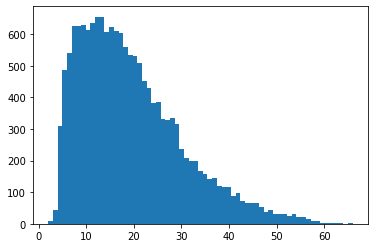

In [13]:
# CODE BLOCK FOR PADDING OF THE SEQUENCES
# FIRST DECIDING HOW MANY WORDS TO TAKE FORM THE ORIGIAL SENTENCES

plt.hist(len_t, bins=np.array(len_t).max()-1)
plt.show()

### AFTER OBSERVING THAT MOST OF THE TWEETS ARE HAVING LENGTH LESS THAT 55 WORDS ###

In [14]:
max_len=55
train_padded=pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='pre')
test_padded=pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='pre')
val_padded=pad_sequences(val_seq, maxlen=max_len, padding='post', truncating='pre')

In [15]:
train_padded[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [16]:
# MAKING THE LABELS
label=dict((c,i) for (i,c) in enumerate(set(train_labels)))
label2=dict((i,c) for (i,c) in enumerate(set(train_labels)))
train_label=np.array([label.get(num) for num in train_labels])
test_label=np.array([label.get(num) for num in (test_labels)])
val_label=np.array([label.get(num) for num in (val_labels)])

In [17]:
label

{'anger': 2, 'fear': 3, 'joy': 5, 'love': 0, 'sadness': 1, 'surprise': 4}

In [18]:
(train_text[2], train_labels[2], train_label[2])

('im grabbing a minute to post i feel greedy wrong', 'anger', 2)

In [43]:
# DEFINING THE ACTUAL MDOEL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

model=Sequential([
                  Embedding(12000,64, input_length=max_len),
                  Bidirectional(LSTM(64, return_sequences=True)),
                  Bidirectional(LSTM(64, return_sequences= True)),
                  Bidirectional(LSTM(64, dropout=0.05 )),
                  Dense(6, activation='softmax')
])
model.compile(metrics='accuracy', loss='sparse_categorical_crossentropy', )

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 55, 64)            768000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 55, 128)           66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 55, 128)           98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 1,032,454
Trainable params: 1,032,454
Non-trainable params: 0
_________________________________________________________________


In [46]:
#TRAINING THE MODEL

his=model.fit(train_padded, train_label, validation_data=(val_padded, val_label), epochs=10)

Epoch 1/10
500/500 [==============================] - 18s 29ms/step - loss: 1.1025 - accuracy: 0.5834 - val_loss: 0.5693 - val_accuracy: 0.8045
Epoch 2/10
500/500 [==============================] - 12s 25ms/step - loss: 0.4086 - accuracy: 0.8619 - val_loss: 0.3416 - val_accuracy: 0.8960
Epoch 3/10
500/500 [==============================] - 12s 25ms/step - loss: 0.2515 - accuracy: 0.9135 - val_loss: 0.2471 - val_accuracy: 0.9175
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 0.1860 - accuracy: 0.9318 - val_loss: 0.2260 - val_accuracy: 0.9255
Epoch 5/10
500/500 [==============================] - 13s 27ms/step - loss: 0.1561 - accuracy: 0.9411 - val_loss: 0.2213 - val_accuracy: 0.9215
Epoch 6/10
500/500 [==============================] - 12s 25ms/step - loss: 0.1348 - accuracy: 0.9503 - val_loss: 0.2131 - val_accuracy: 0.9220
Epoch 7/10
500/500 [==============================] - 12s 24ms/step - loss: 0.1173 - accuracy: 0.9552 - val_loss: 0.2223 - val_accuracy:

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
#model.save_weights("/content/gdrive/MyDrive/kaggle/emotion_1/my_model")

In [33]:
#model.load_weights("/content/gdrive/MyDrive/kaggle/emotion_1/my_model")

In [47]:
model.evaluate(train_padded, train_label)

500/500 [==============================] - 6s 9ms/step - loss: 0.0609 - accuracy: 0.9769


[0.06090499833226204, 0.976937472820282]

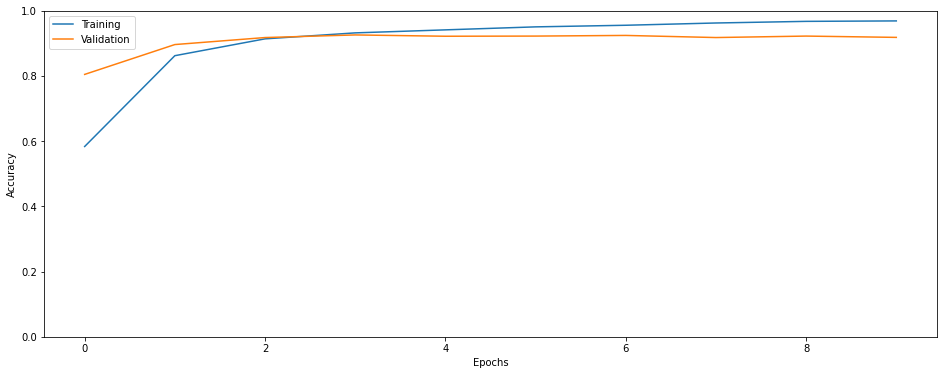

In [48]:

plt.figure(figsize=(16, 6))

plt.plot(his.history.get('accuracy'), label='Training')
plt.plot(his.history.get('val_accuracy'), label='Validation')
plt.ylim([0., 1.])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




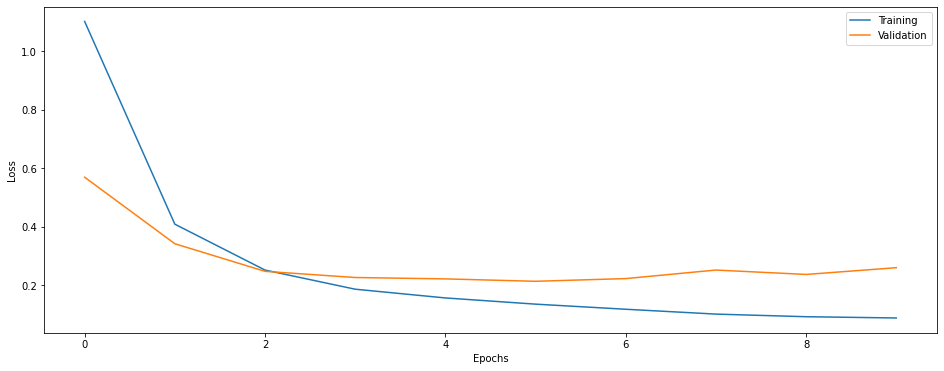

In [49]:
plt.figure(figsize=(16, 6))

plt.plot(his.history.get('loss'), label='Training')
plt.plot(his.history.get('val_loss'), label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [50]:
model.evaluate(test_padded, test_label)

63/63 [==============================] - 1s 10ms/step - loss: 0.2532 - accuracy: 0.9140


[0.25324976444244385, 0.9139999747276306]

In [51]:
## FUNCTION FOR CUSTOM TEXT PREDICTION
def predict(text):
  token.fit_on_texts(text)
  text_seq=text_to_seq([text])
  text_padded=pad_sequences(text_seq, maxlen=max_len, padding='post', truncating='pre')
  p=model.predict(text_padded)
  pred=label2.get(np.argmax(p))
  return pred

In [52]:
# TESTING ON OUR OWN TEXT
text="dogs are cute"
print("THE PREDICTED EMOTION IS : {}".format(predict(text)))

THE PREDICTED EMOTION IS : joy


### STREAMING THE TWEETS USING TWITTER API ###

In [57]:
!pip install emoji


     |████████████████████████████████| 185 kB 9.8 MB/s 
  Created wheel for emoji: filename=emoji-1.4.1-py3-none-any.whl size=186393 sha256=2ea81cf80e0a61d240e5ee17a37ef01d0f1dc20daf0bdb199fa046514cd77c9e
  Stored in directory: /root/.cache/pip/wheels/8e/68/ac/537456a5331f1405779f2b3c2a578429d2f6d7419e440330d8
Successfully built emoji


In [58]:
# MAKING THE NECESSARY IMPORTS
import os
import tweepy as tw
import pandas as pd
import pandas as pd
import re
import emoji
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

# THESE KEYS WILL BE AVAILABLE IN THE TWITTER DEVELOPER ACCOUNT

consumer_key="QSYgnBReKVesOtrIhbdYPNWSs"
consumer_secret="RHL8lhTBhemstAMoQR1cSuSNFPBZWGuW4A6K5nB9TDLptI3QkJ"
access_token="1418540234929676291-1c0HrVBQDvnN0ycMiuQvhD7gtcwbgs"
access_token_secret="dGW1e4VJwalraRvux73FYGDkqqhln5DHtHvYj8lQJCKwh"

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### SEARCHING FOR TWEETS CONTAINING "THE" & CLEANING THE TWEET DATASET
Removing special symbols like @, removing https links, removing hashtags etc

In [70]:
# FOR CLEANING AND GETTING TWEET DATA
new_search = "NEWS"
date_since = "2010-11-16"
tweets = tw.Cursor(api.search,
              q=new_search,
              lang="en",
              since=date_since).items(10)
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) 
    tweet = re.sub(r"(:?:\@|http?\://|https?\://|www)\S+", "", tweet) 
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) 
    tweet = tweet.replace("#", "").replace("_", " ") 
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

In [71]:
# STORING THE ORIGINAL TWEETS IN array_org
array_org=[]
for tweet in tweets:
    array_org.append((tweet.text))

array_org

['RT @Shubham_fd: Fake News Alert. A full report will come on @PoliticoNeo @FDikhana',
 'RT @KingMntungwa: Breaking News 📰 :\n\nLarry Swart says Cyril Ramaphosa paid DCJ Zondo 50 Million to Arrest Pres Jacob Zuma. (Apparently) htt…',
 '@FibonacciNature @KeithGullis @Richieybh @SkyNews Sure, talk all the rubbish you want bud, he’s still said and it’s still news. Suck it up!',
 'RT @billboard: BTS\' "Permission to Dance" is the most popular song in the world, hitting No. 1 on the Billboard Global Charts. \nhttps://t.c…',
 '@ScottMorrisonMP Supportive like this? \n\nhttps://t.co/7DRmBGey2B',
 'Jim Iyke Reveals How He Almost Sold His\xa0Soul https://t.co/xelGwFMxLK',
 'RT @Himansh31018718: #GodMorningThursday\n#thursdaymorning \n#मांसखाना_अल्लाहका_हुक्मनहीं\nSTOP Eating Meat God has laid down the rule that al…',
 "@dbn_lifestyle I don't watch news at all but ngeke ungitshele about anything when it come to current affairs and zo… https://t.co/YHCF4loyTU",
 "RT @SBSNews: The federal governme

In [72]:
# STORING THE CLEANED TWEETS IN array_org
array=[]
for arr in array_org:
    array.append(cleaner(arr))
array

[': Fake News Alert . A full report will come on',
 ': Breaking News 📰 : Larry Swart 50 Million to Arrest . ( Apparently ) …',
 'Sure , talk all the rubbish you want bud , he ’ s still said and it ’ s still news . Suck it up !',
 ': \' " Permission to Dance " is the most popular song in the world , No . 1 on the Billboard Global .',
 'Supportive like this ?',
 'How He Almost Sold His Soul',
 ': ां ा ा ् ा ा ु ् ीं STOP Eating Meat God laid down the rule that al …',
 "I don ' t watch news at all but about anything when it come to current and zo …",
 ": The federal government the UN World Heritage Committee ' s decision to avoid the Great Barrier Reef to its li …",
 ': More male violence under of Covid - any opportunity !']

In [74]:
#i=np.random.randint(10)
i=
print("ORIGINAL TWEET : {}\n".format(array_org[i]))
print("PREDICTED EMOTION OF THE TWEET : '{}' is = {}".format(array[i], predict(array[i])))

ORIGINAL TWEET : @ScottMorrisonMP Supportive like this? 

https://t.co/7DRmBGey2B

PREDICTED EMOTION OF THE TWEET : 'Supportive like this ?' is = surprise
